# Vertex AI Pipelines: Metrics visualization and run comparison using the KFP SDK

## Overview

This notebook shows how to use [the Kubeflow Pipelines (KFP) SDK](https://www.kubeflow.org/docs/components/pipelines/) to build [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines) that generate model metrics and metrics visualizations, and comparing pipeline runs.

Learn more about [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction).

### Objective

This demo uses the following Google Cloud ML services:

- `Vertex AI Pipelines`

The steps performed include:

- Create KFP components:
    - Generate ROC curve and confusion matrix visualizations for classification results
    - Write metrics
- Create KFP pipelines.
- Execute KFP pipelines
- Compare metrics across pipeline runs

### Datasets

The dataset used for this tutorial is the [Wine dataset](https://archive.ics.uci.edu/ml/datasets/wine) from [Scikit-learn builtin datasets](https://scikit-learn.org/stable/datasets.html).

The dataset predicts the origin of a wine.

The dataset used for this tutorial is the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) from [Scikit-learn builtin datasets](https://scikit-learn.org/stable/datasets.html).

The dataset predicts the type of Iris flower species from a class of three species: setosa, virginica, or versicolor.

## Installation

Install the packages required for executing this notebook.

In [20]:
import os

'''
! pip3 install --upgrade --quiet google-cloud-aiplatform \
                                 google-cloud-storage \
                                 kfp \
                                 google-cloud-pipeline-components

if os.getenv("IS_TESTING"):
    ! pip3 install --upgrade matplotlib $USER_FLAG -q
    
'''

'\n! pip3 install --upgrade --quiet google-cloud-aiplatform                                  google-cloud-storage                                  kfp                                  google-cloud-pipeline-components\n\nif os.getenv("IS_TESTING"):\n    ! pip3 install --upgrade matplotlib $USER_FLAG -q\n    \n'

#### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [21]:
PROJECT_ID  = "ibnd-argls-cstmr-demos"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [22]:
REGION = "us-central1"  # @param {type: "string"}

#### UUID

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a uuid for each instance session, and append it onto the name of resources you create in this tutorial.

In [23]:
import random
import string


# Generate a uuid of a specifed length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


UUID = generate_uuid()

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

- *{Note to notebook author: For any user-provided strings that need to be unique (like bucket names or model ID's), append "-unique" to the end so proper testing can occur}*

In [24]:
BUCKET_URI = "gs://ibnd-argls-ml-demos-storage/04_viz_mlops"   # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [25]:
# ! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

#### Service Account

**If you don't know your service account**, try to get your service account using `gcloud` command by executing the second cell below.

In [26]:
SERVICE_ACCOUNT = "998979163436-compute@developer.gserviceaccount.com"  # @param {type:"string"}

In [27]:
import sys

'''
IS_COLAB = "google.colab" in sys.modules

if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    if IS_COLAB:
        shell_output = ! gcloud projects describe  $PROJECT_ID
        project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)
'''

'\nIS_COLAB = "google.colab" in sys.modules\n\nif (\n    SERVICE_ACCOUNT == ""\n    or SERVICE_ACCOUNT is None\n    or SERVICE_ACCOUNT == "[your-service-account]"\n):\n    # Get your service account from gcloud\n    if not IS_COLAB:\n        shell_output = !gcloud auth list 2>/dev/null\n        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()\n\n    if IS_COLAB:\n        shell_output = ! gcloud projects describe  $PROJECT_ID\n        project_number = shell_output[-1].split(":")[1].strip().replace("\'", "")\n        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"\n\n    print("Service Account:", SERVICE_ACCOUNT)\n'

#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step -- you only need to run these once per service account.

In [28]:
'''
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI
'''

'\n! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI\n\n! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI\n'

### Set up variables

Next, set up some variables used throughout the tutorial.
### Import libraries and define constants

In [29]:
import google.cloud.aiplatform as aip
from kfp.v2 import compiler, dsl
from kfp.v2.dsl import ClassificationMetrics
from kfp.v2.dsl import Metrics, Output, component

#### Vertex AI Pipelines constants

Setup up the following constants for Vertex AI Pipelines:

In [30]:
PIPELINE_ROOT = "{}/pipeline_root/iris".format(BUCKET_URI)

## Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [31]:
aip.init(project=PROJECT_ID, staging_bucket=BUCKET_URI)

### Define pipeline components using scikit-learn

In this section, you define some Python function-based components that use scikit-learn to train some classifiers and produce evaluations that can be visualized.

Note the use of the `@component()` decorator in the definitions below. You can optionally set a list of packages for the component to install; the base image to use (the default is a Python 3.7 image); and the name of a component YAML file to generate, so that the component definition can be shared and reused.

#### Define wine_classification component

The first component shows how to visualize an *ROC curve*.
Note that the function definition includes an output called `wmetrics`, of type `Output[ClassificationMetrics]`. You can visualize the metrics in the Pipelines user interface in the Cloud Console.

To do this, this example uses the artifact's `log_roc_curve()` method. This method takes as input arrays with the false positive rates, true positive rates, and thresholds, as [generated by the `sklearn.metrics.roc_curve` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html).

When you evaluate the cell below, a task factory function called `wine_classification` is created, that is used to construct the pipeline definition.  In addition, a component YAML file is created, which can be shared and loaded via file or URL to create the same task factory function.

In [32]:
@component(packages_to_install=["scikit-learn==1.2.2"], base_image="python:3.9")
def wine_classification(wmetrics: Output[ClassificationMetrics]):
    from sklearn.datasets import load_wine
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_curve
    from sklearn.model_selection import cross_val_predict, train_test_split

    X, y = load_wine(return_X_y=True)
    # Binary classification problem for label 1.
    y = y == 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    rfc = RandomForestClassifier(n_estimators=10, random_state=42)
    rfc.fit(X_train, y_train)
    y_scores = cross_val_predict(rfc, X_train, y_train, cv=3, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(
        y_true=y_train, y_score=y_scores[:, 1], pos_label=True
    )
    wmetrics.log_roc_curve(fpr, tpr, thresholds)


# compiler.Compiler().compile(wine_classification, "wine_classification_component.yaml")

#### Define iris_sgdclassifier component

The second component shows how to visualize a *confusion matrix*, in this case for a model trained using `SGDClassifier`.

As with the previous component, you create a `metricsc` output artifact of type `Output[ClassificationMetrics]`.  Then, use the artifact's `log_confusion_matrix` method to visualize the confusion matrix results, as generated by the [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function.

In [33]:
@component(packages_to_install=["scikit-learn==1.2.2"], base_image="python:3.9")
def iris_sgdclassifier(
    test_samples_fraction: float,
    metricsc: Output[ClassificationMetrics],
):
    from sklearn import datasets, model_selection
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import confusion_matrix

    iris_dataset = datasets.load_iris()
    train_x, test_x, train_y, test_y = model_selection.train_test_split(
        iris_dataset["data"],
        iris_dataset["target"],
        test_size=test_samples_fraction,
    )

    classifier = SGDClassifier()
    classifier.fit(train_x, train_y)
    predictions = model_selection.cross_val_predict(classifier, train_x, train_y, cv=3)
    metricsc.log_confusion_matrix(
        ["Setosa", "Versicolour", "Virginica"],
        confusion_matrix(
            train_y, predictions
        ).tolist(),  # .tolist() to convert np array to list.
    )

#### Define iris_logregression component

The third component also uses the "iris" dataset, but trains a `LogisticRegression` model.  It logs model `accuracy` in the `metrics` output artifact.

In [34]:
@component(
    packages_to_install=["scikit-learn==1.2.2"],
    base_image="python:3.9",
)
def iris_logregression(
    input_seed: int,
    split_count: int,
    metrics: Output[Metrics],
):
    from sklearn import datasets, model_selection
    from sklearn.linear_model import LogisticRegression

    # Load digits dataset
    iris = datasets.load_iris()
    # # Create feature matrix
    X = iris.data
    # Create target vector
    y = iris.target
    # test size
    test_size = 0.20

    # cross-validation settings
    kfold = model_selection.KFold(
        n_splits=split_count, random_state=input_seed, shuffle=True
    )
    # Model instance
    model = LogisticRegression()
    scoring = "accuracy"
    results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    print(f"results: {results}")

    # split data
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=input_seed
    )
    # fit model
    model.fit(X_train, y_train)

    # accuracy on test set
    result = model.score(X_test, y_test)
    print(f"result: {result}")
    metrics.log_metric("accuracy", (result * 100.0))

### Define the pipeline

Next, define a simple pipeline that uses the components that were created in the previous section.

In [35]:
PIPELINE_NAME = "metrics-pipeline-v2"


@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline.
    name="metrics-pipeline-v2",
)
def pipeline(seed: int, splits: int):
    wine_classification_op = wine_classification()  # noqa: F841
    iris_logregression_op = iris_logregression(  # noqa: F841
        input_seed=seed, split_count=splits
    )
    iris_sgdclassifier_op = iris_sgdclassifier(test_samples_fraction=0.3)  # noqa: F841

## Compile the pipeline

Next, compile the pipeline.

In [36]:
'''
compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path="tabular_classification_pipeline.yaml",
)
'''
compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path="tabular_classification_pipeline.json",
)

## Run the pipeline

Next, run the pipeline.

In [37]:
DISPLAY_NAME = "iris_" + UUID

'''
job = aip.PipelineJob(
    display_name=DISPLAY_NAME,
    template_path="tabular_classification_pipeline.yaml",
    job_id=f"tabular-classification-v2{UUID}-1",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 7, "splits": 10},
)
'''

job = aip.PipelineJob(
    display_name=DISPLAY_NAME,
    template_path="tabular_classification_pipeline.json",
    job_id=f"tabular-classification-v2{UUID}-1",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 7, "splits": 10},
)


job.run()

Creating PipelineJob
PipelineJob created. Resource name: projects/998979163436/locations/us-central1/pipelineJobs/tabular-classification-v2h1lqfee9-1
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/998979163436/locations/us-central1/pipelineJobs/tabular-classification-v2h1lqfee9-1')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/tabular-classification-v2h1lqfee9-1?project=998979163436
PipelineJob run completed. Resource name: projects/998979163436/locations/us-central1/pipelineJobs/tabular-classification-v2h1lqfee9-1


Click on the generated link to see your run in the Cloud Console.

<!-- It should look something like this as it is running:

<a href="https://storage.googleapis.com/amy-jo/images/mp/automl_tabular_classif.png" target="_blank"><img src="https://storage.googleapis.com/amy-jo/images/mp/automl_tabular_classif.png" width="40%"/></a> -->

In the UI, many of the pipeline DAG nodes will expand or collapse when you click on them.

#### View Pipeline
<img src="images/Screenshot_2024-02-13_2.01.29PM.png" />

## Comparing pipeline runs in the UI

Next, generate another pipeline run that uses a different `seed` and `split` for the `iris_logregression` step.

Submit the new pipeline run:


**pipeline_root :**   Specify a Cloud Storage URI that your pipelines service account can access. The artifacts of your pipeline runs are stored within the pipeline root. 

**display_name :**  The name of the pipeline, this will show up in the Google Cloud console. 

**parameter_values :**  The pipeline parameters to pass to this run. For example, create a dict() with the parameter names as the dictionary keys and the parameter values as the dictionary values. 

**job_id :**  A unique identifier for this pipeline run. If the job ID is not specified, Vertex AI Pipelines creates a job ID for you using the pipeline name and the timestamp of when the pipeline run was started. 

**template_path :**  complete pipeline path

In [40]:
''''
job = aip.PipelineJob(
    display_name="iris_" + UUID,
    template_path="tabular_classification_pipeline.yaml",
    job_id=f"tabular-classification-pipeline-v2{UUID}-2",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 5, "splits": 7},
)
'''
job = aip.PipelineJob(
    display_name="iris_" + UUID,
    template_path="tabular_classification_pipeline.json",
    job_id=f"tabular-classification-pipeline-v2{UUID}-2",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 5, "splits": 7},
)

job.run()

Creating PipelineJob
PipelineJob created. Resource name: projects/998979163436/locations/us-central1/pipelineJobs/tabular-classification-pipeline-v2h1lqfee9-2
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/998979163436/locations/us-central1/pipelineJobs/tabular-classification-pipeline-v2h1lqfee9-2')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/tabular-classification-pipeline-v2h1lqfee9-2?project=998979163436
PipelineJob projects/998979163436/locations/us-central1/pipelineJobs/tabular-classification-pipeline-v2h1lqfee9-2 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/998979163436/locations/us-central1/pipelineJobs/tabular-classification-pipeline-v2h1lqfee9-2 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/998979163436/locations/us-central1/pipelineJobs/tabular-classification-pipeline-v2h1lqfee9-2 current state:
PipelineState.PIPELINE_S

When both pipeline runs have finished, compare their results by navigating to the pipeline runs list in the Cloud Console, selecting both of them, and clicking **COMPARE** at the top of the Console panel.

#### Compare Pipeline
<img src="images/Screenshot_2024-02-13_1.59.57PM.png" />

## Compare the parameters and metrics of the pipelines run from their tracked metadata

Next, you use the Vertex AI SDK for Python to compare the parameters and metrics of the pipeline runs. Wait until the pipeline runs have finished to run the next cell.

In [41]:
pipeline_df = aip.get_pipeline_df(pipeline=PIPELINE_NAME)
print(pipeline_df.head(2))

         pipeline_name                                      run_name  \
0  metrics-pipeline-v2  tabular-classification-pipeline-v2h1lqfee9-2   
1  metrics-pipeline-v2           tabular-classification-v2h1lqfee9-1   

  param.vertex-ai-pipelines-artifact-argument-binding param.input:seed  \
0  {'output:wine-classification-wmetrics': ['proj...                 5   
1  {'output:iris-sgdclassifier-metricsc': ['proje...                 7   

                     param.vmlmd_lineage_integration param.input:splits  \
0  {'pipeline_run_component': {'location_id': 'us...                  7   
1  {'pipeline_run_component': {'project_id': 'ibn...                 10   

                              metric.confusionMatrix  metric.accuracy  \
0  {'rows': [{'row': [33.0, 0.0, 0.0]}, {'row': [...        96.666667   
1  {'rows': [{'row': [33.0, 0.0, 0.0]}, {'row': [...        86.666667   

                            metric.confidenceMetrics  
0  [{'recall': 0.0, 'falsePositiveRate': 0.0, 'co...  
1  [

### Plot parallel coordinates of parameters and metrics

With the metric and parameters in a dataframe, you can perform further analysis to extract useful information. The following example compares data from each run using a parallel coordinate plot.

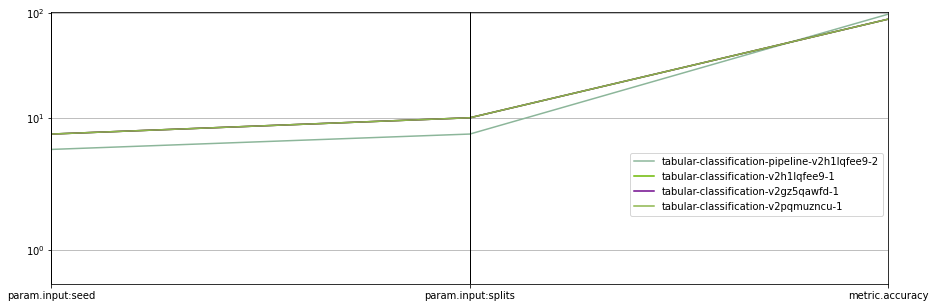

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = [15, 5]

pipeline_df["param.input:seed"] = pipeline_df["param.input:seed"].astype(np.float16)
pipeline_df["param.input:splits"] = pipeline_df["param.input:splits"].astype(np.float16)

ax = pd.plotting.parallel_coordinates(
    pipeline_df.reset_index(level=0),
    "run_name",
    cols=["param.input:seed", "param.input:splits", "metric.accuracy"],
)
ax.set_yscale("symlog")
ax.legend(bbox_to_anchor=(1.0, 0.5))

### Plot ROC curve and calculate AUC number

In addition to basic metrics, you can extract complex metrics and perform further analysis using the `get_pipeline_df` method.

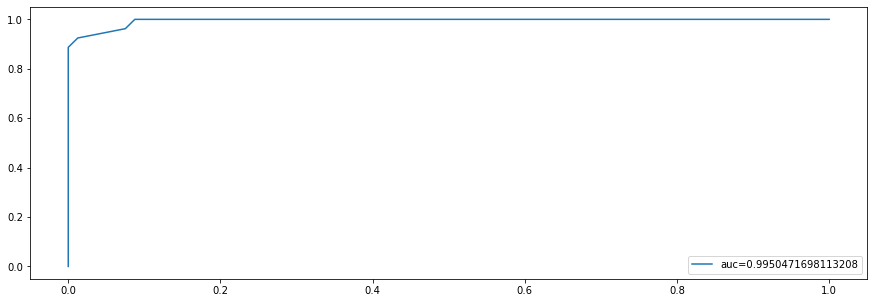

In [43]:
try:
    df = pd.DataFrame(pipeline_df["metric.confidenceMetrics"][0])
    auc = np.trapz(df["recall"], df["falsePositiveRate"])
    plt.plot(df["falsePositiveRate"], df["recall"], label="auc=" + str(auc))
    plt.legend(loc=4)
    plt.show()
except Exception as e:
    print(e)

# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial -- *Note:* this is auto-generated and not all resources may be applicable for this tutorial:

In [ ]:
'''
import os

delete_bucket = False

job.delete()
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -r $BUCKET_URI

! rm -rf tabular_classification_pipeline.yaml
'''